In [2]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

## Einige hilfreiche Funktionen zur für spätere Nutzung definieren

In [4]:
def avg_circles(circles, b):
    avg_x = 0
    avg_y = 0
    avg_r = 0
    for i in range(b):
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x / (b))
    avg_y = int(avg_y / (b))
    avg_r = int(avg_r / (b))
    return avg_x, avg_y, avg_r


def dist_2_pts(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def find_point_on_circle(center_x, center_y, r, angle_in_degrees):
    angle_in_degrees *= -1
    angle_in_radians = math.radians(90-angle_in_degrees)

    x = int(r * math.cos(angle_in_radians) + center_x)
    y = int(r * math.sin(angle_in_radians) + center_y)

    return x, y

def show_image(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.xticks([]), plt.yticks([])

## Bild auswählen

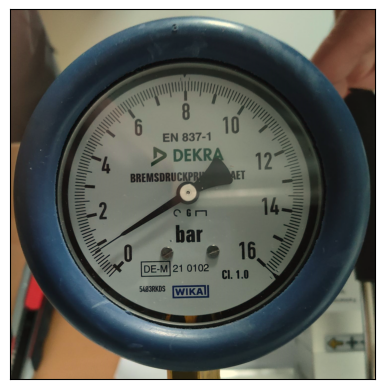

In [5]:
file_name='gauge-3'
file_type='png'

img = cv2.imread('%s.%s' % (file_name, file_type))

show_image(img)

## Kalibrierungs-Overlay erstellen
Da unterschiedliche Messgeräte unterschiedliche Layouts haben können, muss der User das Messgerät kalibrieren.
Zuerst muss die Skala des Messgeräts gefunden und Markiert werden, da diese Kreisfürmig ist wird der **Hough-Circles-Algorithmus** verwendet, der dazu dient, Kreise zu finden. Anschließend werden alle gefundenen Kreise zu einem Durchschnitsskreis komprimiert, dieser stellt die das "Ziffernblatt" des Messgeräts dar.

Danach werden entlang dieses Kreises alle 10° ein Strich gesetzt und die zugehörige Beschriftung dieser Striche

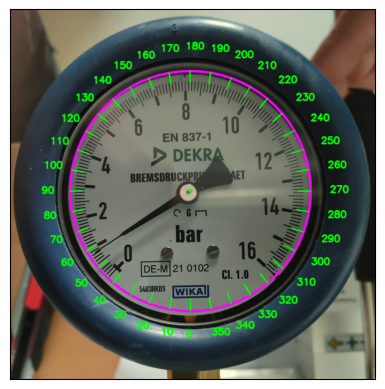

In [9]:
height, width = img.shape[:2]

gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray_blurred = cv2.medianBlur(gray_image, 5)

circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, 1, 20, np.array([]), 100, 50, minRadius=int(height * 0.25), maxRadius=int(height * 0.5))

# average found circles, found it to be more accurate than trying to tune HoughCircles parameters to get just the right one
a, b, c = circles.shape
x, y, r = avg_circles(circles, b)

calibration_image = img.copy()

# draw center and circle
cv2.circle(calibration_image, (x, y), r, (255, 0, 255), 3, cv2.LINE_AA)  # draw circle
cv2.circle(calibration_image, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)  # draw center of circle

separation = 10.0  # in degrees
interval = int(360 / separation)
p1 = np.zeros((interval, 2))  # set empty arrays
p2 = np.zeros((interval, 2))
p_text = np.zeros((interval, 2))
for i in range(0, interval):
    for j in range(0, 2):
        if (j % 2 == 0):
            p1[i][j] = x + 0.9 * r * np.cos(separation * i * 3.14 / 180)  # point for lines
        else:
            p1[i][j] = y + 0.9 * r * np.sin(separation * i * 3.14 / 180)
text_offset_x = 10
text_offset_y = 5
for i in range(0, interval):
    for j in range(0, 2):
        if (j % 2 == 0):
            p2[i][j] = x + r * np.cos(separation * i * 3.14 / 180)
            p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos(
                (separation) * (i + 9) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees
        else:
            p2[i][j] = y + r * np.sin(separation * i * 3.14 / 180)
            p_text[i][j] = y + text_offset_y + 1.2 * r * np.sin(
                (separation) * (i + 9) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

# add the lines and labels to the image
for i in range(0, interval):
    cv2.line(calibration_image, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])), (0, 255, 0), 2)
    cv2.putText(calibration_image, '%s' % (int(i * separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX,
                0.7, (0, 255, 0), 2, cv2.LINE_AA)
    
# cv2.imwrite('%s-calibration.%s' % (file_name, file_type), calibration_image)
# print('Kalibrierungs-Datei erstellt: %s-calibration.%s' % (file_name, file_type))
show_image(calibration_image)

### Werte festlegen
entweder per Inputs:

In [6]:
min_angle = input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
max_angle = input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
min_value = input('Min value: ') #usually zero
max_value = input('Max value: ') #maximum reading of the gauge
units = input('Enter units: ')

oder Hardcoded:

In [13]:
min_angle = 44
max_angle = 315
min_value = 0
max_value = 16
units = "bar"

### Ermittlung des Winkels der Nadel
um die Position der Nadel zu ermitteln wird folgender Prozess durchlaufen:
1. Das Bild mit dem Threshold 60 in eine Bitmap (Schwarz und Weiß) umwandeln und dann invertieren
2. Beim Startwinkel startend in 1° Schritten schauen, welche Linie von der Mitte bis zum Rand am meisten weiße Pixel enthält
3. Winkel und Position der Nadelspitze speichern

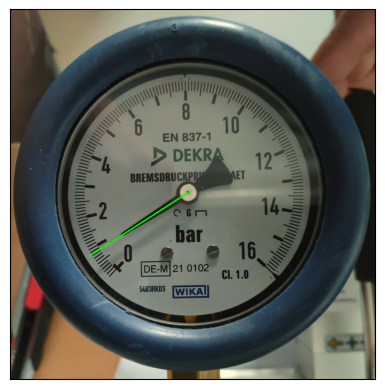

In [14]:
thresh = 60

center = (x, y)
radius = r

th, thresh_image = cv2.threshold(gray_image, thresh, 255, cv2.THRESH_BINARY_INV);

# Initializing variables
max_pixels = 0
needle_angle = 0
needle_end_point = (0, 0)

for angle in range(int(min_angle), int(max_angle)):
    angle_radians = math.radians(angle)
    start_point = center
    end_point = find_point_on_circle(center_x=x, center_y=y, r=radius, angle_in_degrees=angle)
    line_pixels = cv2.line(np.zeros(thresh_image.shape), start_point, end_point, 1, 1)
    no_of_pixels = len(np.nonzero(cv2.bitwise_and(thresh_image, thresh_image, mask=np.uint8(line_pixels)))[0])

    # Update when we get maximum white pixels on line
    if no_of_pixels > max_pixels:
        max_pixels = no_of_pixels
        needle_angle = angle
        needle_end_point = end_point
        
line_image = img.copy();
cv2.line(line_image, center, needle_end_point, (0, 255, 0), 2)
show_image(line_image)

## Berechnen des Wertes an der Stelle der Nadel
Um den Wert an der Stelle, auf die die Nadel zeigt zu berechnen wird folgende Formel verwendet: (Winkel in Grad als Fließkommazahl)
$$
\frac{\text{nadelWinkel} - \text{startWinkel}}{\text{endWinkel} - \text{startWinkel}} * (\text{maxWert} - \text{minWert}) + \text{startWert} = \text{Wert des Messgeräts}
$$
#### Erklärung
1. Prozentuale Position des Zeigers im Messbereich ermitteln
2. Prozentzahl mit dem Wertebereich multiplizieren

In [15]:
angle_range = max_angle - min_angle
start_to_needle_range = needle_angle - min_angle
value_range = max_value - min_value

measured_value = start_to_needle_range / angle_range * value_range + min_value

print ("Current reading: %s %s" %(round(measured_value, 1), units))

Current reading: 0.8 bar
